<a href="https://colab.research.google.com/github/Motsepe-Jr/testing2/blob/master/Classifying_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
## Prepapring the data

In [3]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Split the dataset into validationand training 
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Shape:  torch.Size([128, 1, 28, 28])


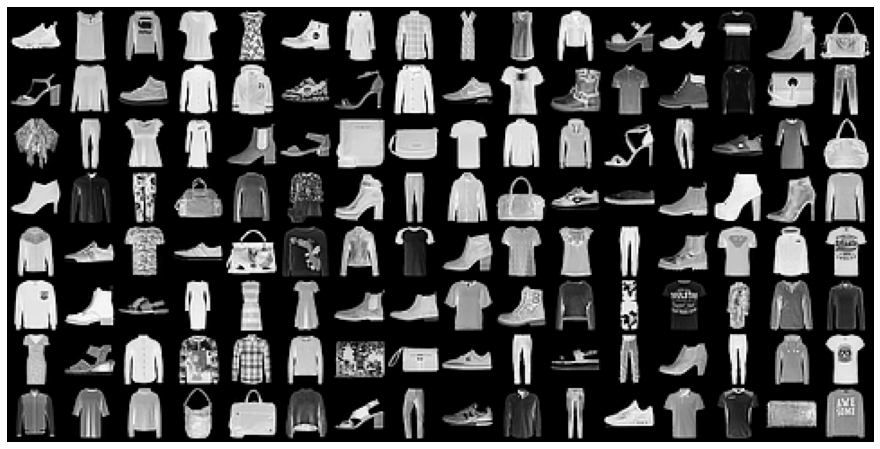

In [6]:
for images, _ in train_loader:
  print('Shape: ', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2,0)))
  break

In [7]:
for images, _ in train_loader:
  print(images.permute(1, 2, 0, 3).shape)
  print(_)
  break

torch.Size([1, 28, 128, 28])
tensor([2, 3, 4, 0, 2, 0, 4, 6, 0, 5, 3, 5, 2, 3, 2, 0, 5, 1, 9, 1, 9, 0, 3, 0,
        1, 7, 2, 9, 6, 6, 4, 9, 9, 4, 9, 7, 2, 0, 7, 9, 8, 2, 7, 9, 7, 3, 6, 3,
        0, 5, 6, 1, 7, 1, 5, 4, 1, 7, 9, 1, 5, 5, 2, 2, 6, 3, 5, 0, 4, 1, 6, 5,
        5, 3, 2, 7, 8, 1, 5, 3, 2, 7, 8, 4, 3, 6, 3, 7, 1, 6, 9, 7, 0, 6, 0, 3,
        0, 3, 7, 5, 4, 3, 7, 7, 0, 0, 2, 7, 3, 9, 9, 7, 3, 4, 1, 4, 5, 1, 3, 6,
        6, 0, 0, 2, 8, 2, 9, 0])


In [ ]:
# MODEL 

In [8]:
  def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class MnistModel(nn.Module):
  "Feedfoward neural network with  1 hidden layer"
  def __init__(self, in_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, 16)
    # hiddden layer e
    self.linear2 = nn.Linear(16, 32)
    # out layer
    self.linear3 = nn.Linear(32, out_size)

  def forward(self, xb):
    # flatten image
    out = xb.view(xb.size(0), -1)
    # get intermediate oupt
    out = self.linear1(out)
    # apply activtion functoion
    out = F.relu(out)
    # get intermidate output from linear2
    out =self.linear2(out)
    # apply actiob function
    out = F.relu(out)
    # get predictions using out layer
    out = self.linear3(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images) # get predictions
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss' :loss, "val_acc":acc}


  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' :epoch_loss.item(), "val_acc":epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print('Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['val_loss'], result['val_acc']))



In [17]:
# Using GPU
torch.cuda.is_available()

# import tensorflow as tf
# tf.test.gpu_device_name()

True

In [18]:
# Training the model
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history



In [19]:
input_size = 784
num_classes = 10

In [32]:
model = MnistModel(input_size, out_size=num_classes)

In [33]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10312499850988388, 'val_loss': 2.300985336303711}]

In [34]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0820, val_acc: 0.5881
Epoch [1], val_loss: 0.8505, val_acc: 0.6567
Epoch [2], val_loss: 0.7419, val_acc: 0.7197
Epoch [3], val_loss: 0.6604, val_acc: 0.7405
Epoch [4], val_loss: 0.6558, val_acc: 0.7383


In [27]:
history += fit(5  , 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4792, val_acc: 0.8259
Epoch [1], val_loss: 0.4786, val_acc: 0.8281
Epoch [2], val_loss: 0.4735, val_acc: 0.8310
Epoch [3], val_loss: 0.4709, val_acc: 0.8346
Epoch [4], val_loss: 0.4790, val_acc: 0.8273


Text(0.5, 1.0, 'Loss vs No of Epochs')

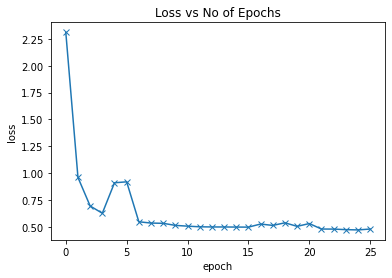

In [29]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No of Epochs')

In [28]:
history

[{'val_acc': 0.10029296576976776, 'val_loss': 2.312854766845703},
 {'val_acc': 0.580273449420929, 'val_loss': 0.9596201181411743},
 {'val_acc': 0.733105480670929, 'val_loss': 0.6939634680747986},
 {'val_acc': 0.7398437261581421, 'val_loss': 0.6262778043746948},
 {'val_acc': 0.6865234375, 'val_loss': 0.9101592898368835},
 {'val_acc': 0.7056640386581421, 'val_loss': 0.9190036058425903},
 {'val_acc': 0.7880859375, 'val_loss': 0.5467629432678223},
 {'val_acc': 0.804492175579071, 'val_loss': 0.5347590446472168},
 {'val_acc': 0.8067382574081421, 'val_loss': 0.5323643684387207},
 {'val_acc': 0.819140613079071, 'val_loss': 0.5131639242172241},
 {'val_acc': 0.82177734375, 'val_loss': 0.5059693455696106},
 {'val_acc': 0.824511706829071, 'val_loss': 0.49997806549072266},
 {'val_acc': 0.822949230670929, 'val_loss': 0.4985349774360657},
 {'val_acc': 0.825488269329071, 'val_loss': 0.4982704222202301},
 {'val_acc': 0.82421875, 'val_loss': 0.49748292565345764},
 {'val_acc': 0.8232421875, 'val_loss': 0

In [35]:
### prediction
def predict_samples(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _,  preds = torch.max(yb, dim=1)
  return preds[0].item()

Label:  Ankle boot Predicted Ankle boot


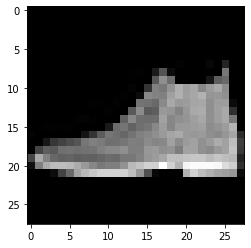

In [44]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ', dataset.classes[label], 'Predicted', dataset.classes[predict_samples(img, model)])